# Analysis of Text Matching Data Generated from JSTOR Dataset 

In [1]:
import pandas as pd
import numpy as np
#import spacy
import re
import json
import altair as alt
#from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

/usr/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [3]:
textALength = len(mm) 

In [4]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [5]:
def getChapters(text): 
    chapters = []
    for i, loc in enumerate(chapterLocations): 
        if i != len(chapterLocations)-1: 
            chapter = mm[loc:chapterLocations[i+1]]
            chapters.append(chapter)
    return chapters

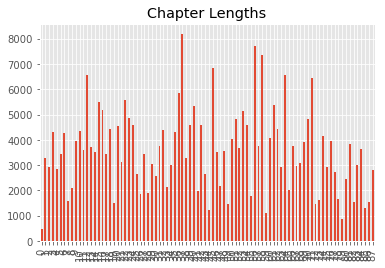

In [6]:
chapters = getChapters(mm)
chapterLengths = [len(chapter.split()) for chapter in chapters]
chapterLengthsSeries = pd.Series(chapterLengths)
chapterLengthsSeries.plot(kind='bar', title='Chapter Lengths')

In [7]:
df = pd.read_json('../data/e3.json')

In [8]:
df['Decade'] = df['year'] - (df['year'] % 10)
# df['Locations in A'] = df['matches'].apply(lambda x: x[1])
# df['NumMatches'] = df['matches'].apply(lambda x: x[0])

In [9]:
sum([len(item) for item in df['Locations in A'].values])

1794

# How many articles do we have? 

In [10]:
len(df) # Total articles with "Middlemarch" mentioned somewhere

6069

Find only those with non-trivial quotations from Middlemarch: 

In [11]:
articlesWithMatches = df[df['Locations in A'].apply(lambda x: len(x) > 0)]
articlesWithMatches.year.describe()

count     489.000000
mean     1991.871166
std        18.477106
min      1873.000000
25%      1980.000000
50%      1995.000000
75%      2007.000000
max      2016.000000
Name: year, dtype: float64

## How many articles do we have published in each year? 

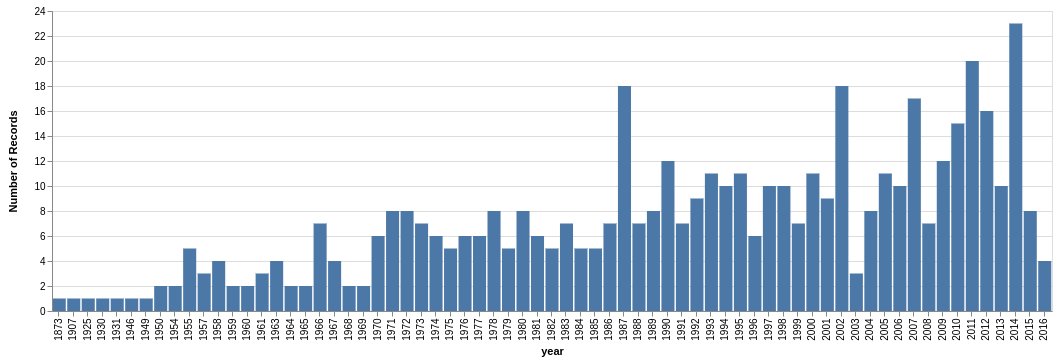

In [13]:
alt.Chart(articlesWithMatches).mark_bar().encode(x='year:O', y='count()').properties(width=1000)

In [14]:
df.columns

Index(['Locations in A', 'Locations in B', 'author', 'coverdate', 'disc_name',
       'doi', 'id', 'jcode', 'journal', 'la', 'no', 'numMatches', 'pages',
       'publisher_name', 'sp', 'srcHtml', 'title', 'topics', 'ty', 'vo',
       'year', 'Decade', 'Quoted Words', 'Locations in A with Wordcounts',
       'Wordcounts'],
      dtype='object')

# Average Numbers of Quoted Words Per Item

In [15]:
df['Quoted Words'].describe()

count    6069.000000
mean       19.240896
std       105.153455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2498.000000
Name: Quoted Words, dtype: float64

In [16]:
articlesWithMatches['Quoted Words'].describe()

count     489.000000
mean      238.799591
std       291.466263
min        13.000000
25%        68.000000
50%       141.000000
75%       281.000000
max      2498.000000
Name: Quoted Words, dtype: float64

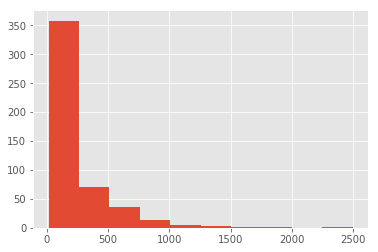

In [20]:
articlesWithMatches['Quoted Words'].hist()

In [27]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations, useWordcounts=True, normalize=True):
    """ Turning on useWordcounts makes it so that it's weighted by wordcount. 
    Turning it off uses raw numbers of quotations. """
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts.copy()
        else: 
            decadeDict[decade] += locationsAndWordcounts.copy()
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    if useWordcounts: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  weights=[loc[1] for loc in locations],
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    else: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    if normalize: 
        decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    chunk = mm[locRange[0]:locRange[1]]
    return len(chunk.split())

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def extractWordcounts(locsAndWordcounts): 
    """ 
    Takes pairs of location ranges and wordcounts, 
    and returns just the wordcounts. 
    """
    return [item[1] for item in locsAndWordcounts 
            if len(locsAndWordcounts) > 0]

def synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    if useWordcounts: 
        binned = np.histogram(starts, bins=bins, 
                              weights=counts, range=(0, textALength))
    else: 
        binned = np.histogram(starts, bins=bins, 
                              range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()
    
def plotSynchronicAnalysis(s, useWordcounts=True): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    if useWordcounts: 
        ax.set_ylabel('Number of Words Quoted')
    else: 
        ax.set_ylabel('Number of Quotations')

In [11]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [12]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

In [13]:
# Verify that the diachronic wordcounts are the same as the synchronic wordcounts
decadeSums = diachronicAnalysis(df, decades=(1700, 2020), useWordcounts=True, normalize=False).sum(axis=1)
decadeSums.sum()

95120.0

In [14]:
chapterSums = synchronicAnalysis(df)
chapterSums.sum()

95120

# Quotation Length Statistics

In [15]:
df['Wordcounts'] = df['Locations in A with Wordcounts'].apply(extractWordcounts)

In [16]:
wordcounts = []
for countSet in df['Wordcounts'].values: 
    for count in countSet: 
        wordcounts.append(count)

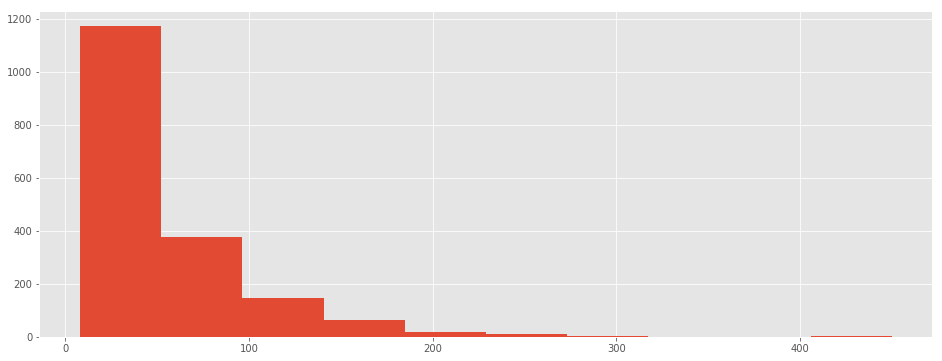

In [17]:
pd.Series(wordcounts).hist()

# Number of Quotes (and words Quoted) by Chapter

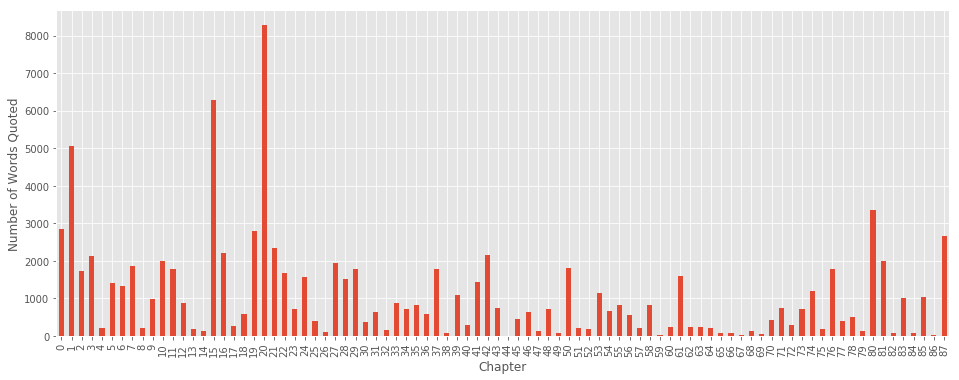

In [18]:
plotSynchronicAnalysis(synchronicAnalysis(df))

In [19]:
synchronicAnalysis(df, useWordcounts=True).to_csv('../papers/spring2017-middlemarch-paper/data/num-words-quoted-per-chapter.csv.csv')

In [20]:
allMatches = []
for group in df['Locations in A'].values: 
    for pair in group: 
        allMatches.append(pair)

In [21]:
len(allMatches)

1794

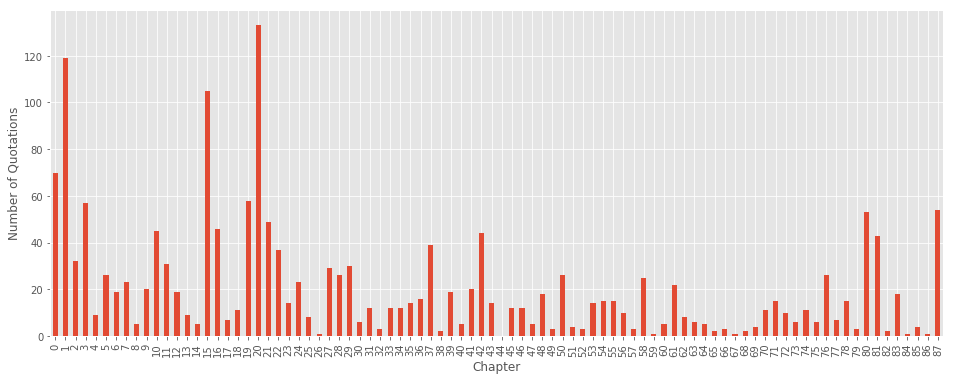

In [22]:
plotSynchronicAnalysis(synchronicAnalysis(df, useWordcounts=False), useWordcounts=False)

In [23]:
# Get the raw number of quotations of Chapter 20: 
synchronicAnalysis(df, useWordcounts=False)[20]

133

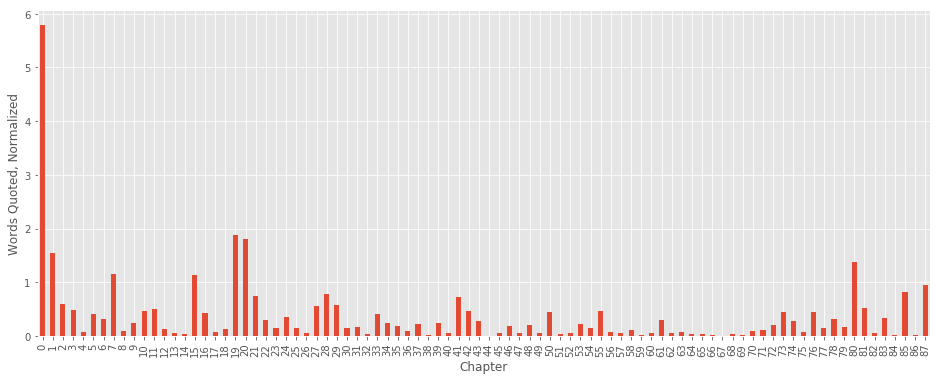

In [24]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')

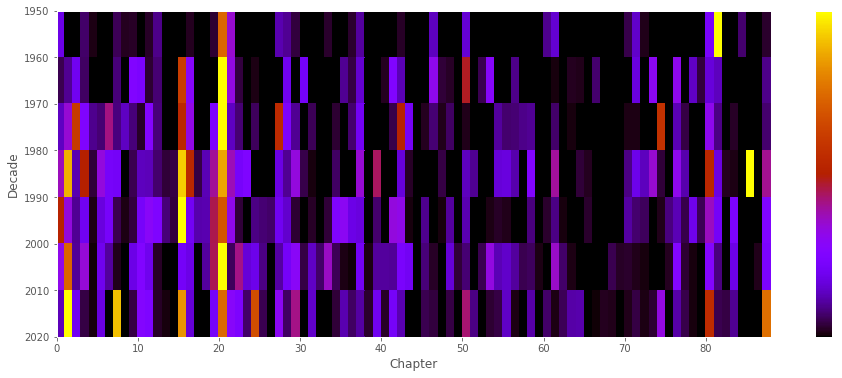

In [29]:
plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations))

In [26]:
# Export image for publication
# plotDiachronicAnalysis(diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations), save=True)

In [30]:
# Get the normalized proportion of, say, Chapter 20 in 1950: 
diachronicAnalysis(df)[20][1950]

0.73639274279615796

# By (Guessed) Gender of Author

In [31]:
maleNames, femaleNames = names.words('male.txt'), names.words('female.txt')
maleNames = [name.lower() for name in maleNames]
femaleNames = [name.lower() for name in femaleNames]

In [32]:
def guessGender(name): 
    name = name.split()[0].lower() # Grab the first name. 
    if name in maleNames and name in femaleNames: 
        return 'A' #Ambiguous
    elif name in maleNames: 
        return 'M'
    elif name in femaleNames: 
        return 'F'
    else: 
        return 'U'

def averageGender(names): 
    if type(names) != list: 
        return 'U'
    genderGuesses = [guessGender(name) for name in names]
    stats = Counter(genderGuesses).most_common()
    if len(stats) == 1: 
        # Only one author. We can just use that's author's gender guess. 
        return stats[0][0]
    elif stats[0][1] == stats[1][1]: # There's a tie. 
        return 'A' # Ambiguous. 
    else: 
        return stats[0][0] # Return the most common gender. 
        

In [33]:
df['gender'] = df['author'].apply(averageGender)
dfF = df.loc[df['gender'] == 'F']
dfM = df.loc[df['gender'] == 'M']

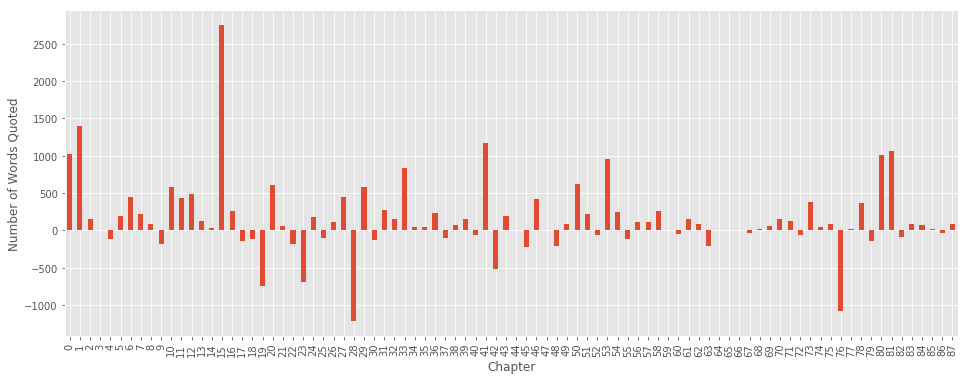

In [34]:
# Differences in citations between genders. 
plotSynchronicAnalysis(synchronicAnalysis(dfM) - synchronicAnalysis(dfF))

# By (Guessed) Country of Publication

In [35]:
def getFirst(row): 
    if type(row) == list: 
        return row[0]
    else: 
        return row

topPublishers = df['publisher_name'].apply(getFirst).value_counts()

In [36]:
publishers = topPublishers[:80].index

In [37]:
publishers = publishers.tolist()

In [38]:
def getCountry(publisher): 
    brits = ['Oxford University Press', 'Cambridge University Press', 'Modern Humanities Research Association', \
             'BMJ', 'Taylor & Francis, Ltd.', 'Edinburgh University Press', \
             'Royal Society for the Encouragement of Arts, Manufactures and Commerce']
    canadians = ['Victorian Studies Association of Western Canada'] 
    if type(publisher) != list: 
        return 'Unknown'
    publisher = publisher[0]
    if publisher in brits: 
        return 'Britain' 
    elif publisher in canadians or 'Canada' in publisher: 
        return 'Canada' 
    elif 'GmbH' in publisher: 
        return 'Germany'
    elif 'estudios' in publisher: 
        return 'Spain'
    elif 'France' in publisher: 
        return 'France' 
    elif 'Ireland' in publisher: 
        return 'Ireland'
    else: 
        return 'US'

In [39]:
df['country'] = df['publisher_name'].apply(getCountry)

In [40]:
df['country'].value_counts()

US         3901
Unknown    1247
Britain     825
Canada       59
Germany      15
Spain         8
Ireland       8
France        6
Name: country, dtype: int64

In [41]:
dfBrits = df.loc[df['country'] == 'Britain']
dfYanks = df.loc[df['country'] == 'US']
dfCanadians = df.loc[df['country'] == 'Canada']

In [42]:
# Since British authors are greatly outnumbered in this corpus, we should normalize the data. 
britsHist = synchronicAnalysis(dfBrits) 
normBrits = britsHist.div(britsHist.max())
yanksHist = synchronicAnalysis(dfYanks)
normYanks = yanksHist.div(yanksHist.max())

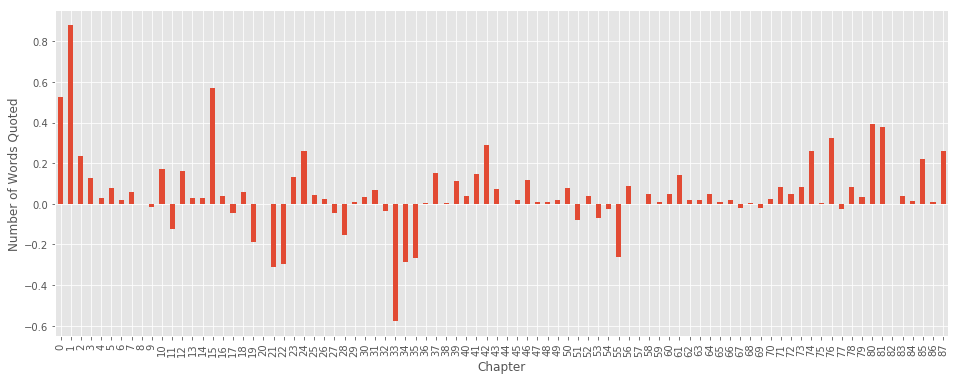

In [43]:
plotSynchronicAnalysis(normYanks - normBrits)

# By Journal

In [44]:
# Look at the top journals. 
journalStats = df['journal'].value_counts()
journalStats[:10]

Victorian Studies                            424
George Eliot - George Henry Lewes Studies    206
Nineteenth-Century Fiction                   192
The Modern Language Review                   188
The Review of English Studies                185
NOVEL: A Forum on Fiction                    126
Nineteenth-Century Literature                126
Studies in the Novel                         120
Studies in English Literature, 1500-1900      85
ELH                                           77
Name: journal, dtype: int64

In [45]:
journalList = journalStats.index

Compare the specialist journal, "George Eliot - George Henry Lewes Studies," with all other journals. 

In [46]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [47]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

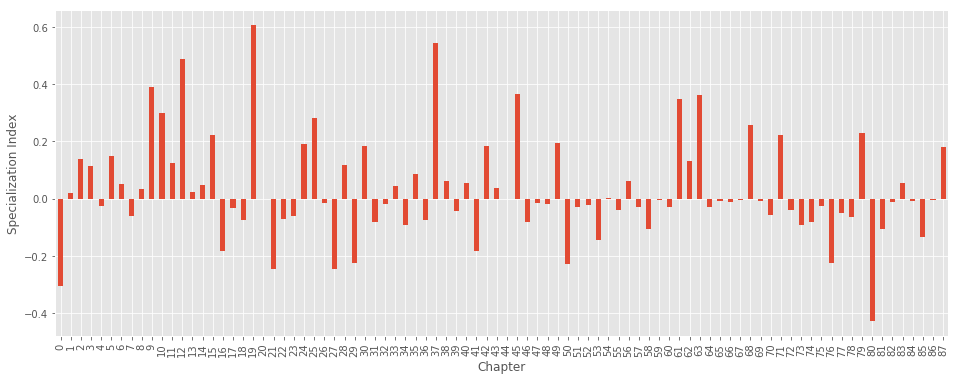

In [64]:
fig = plt.figure()
ax = (normGE - normOther).plot(kind='bar')
fig.add_subplot(ax)
ax.set_xlabel('Chapter')
ax.set_ylabel('Specialization Index')
# Save a big version for publication. 
fig.savefig('specialization.png', bboxinches='tight', dpi=300)

In [56]:
journals = pd.DataFrame({title: synchronicAnalysis(df.loc[df['journal'] == title]) for title in journalList }).T

In [57]:
cutoff = 1500
topJournals = journals.loc[journals.sum(axis=1) > cutoff]
otherJournals = journals.loc[journals.sum(axis=1) < cutoff]
topJournals.loc['Other'] = otherJournals.sum()

/home/jon/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


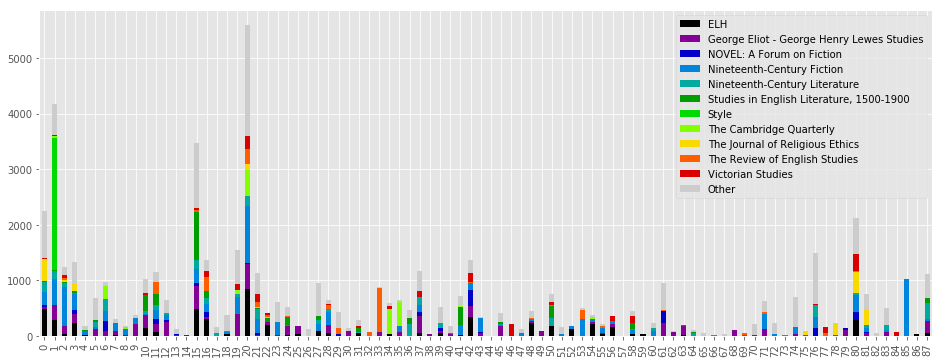

In [58]:
topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')

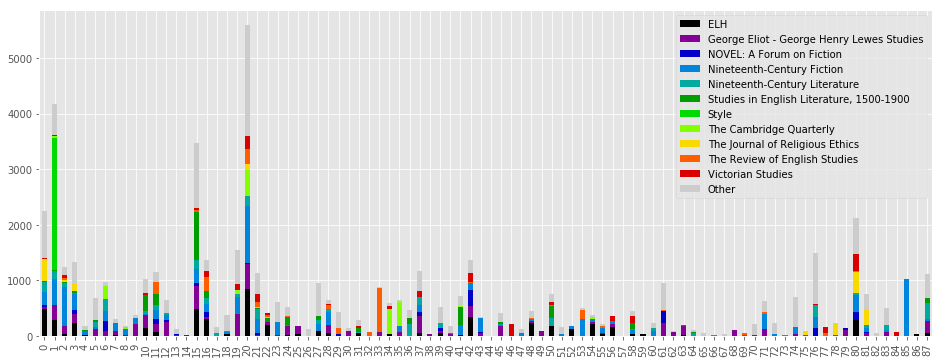

In [63]:
ax = topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')
fig = ax.get_figure()
fig.savefig('synchronic-journals.png', bboxinches='tight', dpi=300)

# Detour: Ch. 15

In [49]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 322051: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15s.append(row)
                    ids.append(row.id)

In [50]:
# Get the titles of those articles. 
[item.title for item in chap15s]

[['"Wrinkled Deep in Time": The Alexandria Quartet as Many-Layered Palimpsest'],
 ["The Victorian Discourse of Gambling: Speculations on Middlemarch and the Duke's Children"],
 ['George Eliot\'s Scrupulous Research: The Facts behind Eliot\'s Use of the "Keepsake in Middlemarch"'],
 ['ERZÄHLERISCHE OBJEKTIVITÄT, ,AUTHORIAL INTRUSIONS‘ UND ENGLISCHER REALISMUS'],
 ['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript'],
 ["The Turn of George Eliot's Realism"],
 ['Transformation of Rage',
  "Mourning and Creativity in George Eliot's Fiction",
  'The Vast Wreck of Ambitious Ideals in Middlemarch'],
 ['SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"'],
 ['Steamboat Surfacing: Scott and the English Novelists'],
 ['Heroic Commitment in Richardson, Eliot, and James',
  'POWER AS PARTIALITY IN MIDDLEMARCH'],
 ['AN END TO CONVERTING PATIENTS\' STOMACHS INTO DRUG-SHOPS: LYDGATE\'S NEW METHOD OF CHARGING HIS PATIENTS IN "MIDDLEMARCH"'],
 ['Dangerous Crossings: Dickens, Digressio

In [51]:
ch15Topics =  [item.topics for item in chap15s]
chap15TopicsFlat = [item for sublist in ch15Topics for item in sublist]
Counter(chap15TopicsFlat).most_common(20)

[('Love', 8),
 ('Vocation', 8),
 ('Novelists', 8),
 ('Pity', 8),
 ('Gossip', 6),
 ('Sympathy', 6),
 ('Irony', 6),
 ('Narratology', 5),
 ('Novels', 5),
 ('Gambling', 4),
 ('Marriage ceremonies', 4),
 ('Vanity', 4),
 ('Antitheses', 4),
 ('Heroism', 4),
 ('Pathos', 4),
 ('Melodrama', 4),
 ('Humor', 4),
 ('Asceticism', 3),
 ('Aristocracy', 3),
 ('Pickles', 3)]